"""
Algorithmic Bias Analysis in AI-Driven Personalized Medicine
============================================================

This script analyzes potential algorithmic biases in AI models used for
personalized medicine treatment recommendations, including feature selection,
model training, and interpretation biases.
"""

In [22]:
# Import all necessary libraries for data analysis, modeling, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## The Analyzer Class (all methods)

In [23]:
# This class encapsulates all logic for analyzing algorithmic bias in synthetic genomic data
class AlgorithmicBiasAnalyzer:
    def __init__(self):
        # Initialize storage for data, models, and bias metrics
        self.data = None
        self.models = {}
        self.bias_metrics = {}

    def create_synthetic_genomic_data(self, n_samples=1000):
        """
        Generate a synthetic dataset that mimics real-world genomic and demographic bias.
        """
        np.random.seed(42)
        n_genes = 50
        gene_names = [f'GENE_{i:03d}' for i in range(n_genes)]
        data = {}
        # Define ethnic groups and their proportions (introducing bias)
        ethnicities = ['White', 'Black/African American', 'Asian', 'Hispanic/Latino']
        ethnicity_weights = [0.75, 0.08, 0.05, 0.12]
        data['ethnicity'] = np.random.choice(ethnicities, n_samples, p=ethnicity_weights)
        data['age'] = np.random.normal(65, 15, n_samples)
        data['gender'] = np.random.choice(['Male', 'Female'], n_samples, p=[0.45, 0.55])
        # Generate gene expression features, with the first 10 genes showing ethnic bias
        for i, gene in enumerate(gene_names):
            if i < 10:
                base_expression = np.random.normal(0, 1, n_samples)
                ethnic_effects = {
                    'White': 0.5,
                    'Black/African American': -0.3,
                    'Asian': 0.2,
                    'Hispanic/Latino': -0.1
                }
                ethnic_adjustment = np.array([ethnic_effects[eth] for eth in data['ethnicity']])
                data[gene] = base_expression + ethnic_adjustment
            else:
                data[gene] = np.random.normal(0, 1, n_samples)
        # Create a synthetic treatment response with bias
        genomic_score = sum([data[gene] for gene in gene_names[:20]]) / 20
        ethnic_bias = np.array([0.3 if eth == 'White' else -0.2 for eth in data['ethnicity']])
        noise = np.random.normal(0, 0.5, n_samples)
        response_prob = 1 / (1 + np.exp(-(genomic_score + ethnic_bias + noise)))
        data['treatment_response'] = (response_prob > 0.5).astype(int)
        # Add additional clinical features
        data['bmi'] = np.random.normal(25, 5, n_samples)
        data['smoking_status'] = np.random.choice(['Never', 'Former', 'Current'], n_samples, p=[0.4, 0.4, 0.2])
        data['comorbidity_count'] = np.random.poisson(2, n_samples)
        return pd.DataFrame(data)

    def analyze_feature_selection_bias(self):
        """
        Analyze how feature importance varies across ethnic groups.
        """
        print("=== FEATURE SELECTION BIAS ANALYSIS ===\n")
        feature_cols = [col for col in self.data.columns if col.startswith('GENE_')]
        X = self.data[feature_cols + ['age', 'bmi', 'comorbidity_count']]
        y = self.data['treatment_response']
        ethnicities = self.data['ethnicity'].unique()
        feature_importance_by_ethnicity = {}
        # Train a model for each ethnicity and record feature importances
        for ethnicity in ethnicities:
            mask = self.data['ethnicity'] == ethnicity
            X_subset = X[mask]
            y_subset = y[mask]
            if len(X_subset) > 10:
                model = RandomForestClassifier(n_estimators=100, random_state=42)
                model.fit(X_subset, y_subset)
                importance = model.feature_importances_
                feature_importance_by_ethnicity[ethnicity] = dict(zip(X.columns, importance))
        print("Feature Importance by Ethnicity (Top 10 features):")
        for ethnicity, importance_dict in feature_importance_by_ethnicity.items():
            print(f"\n{ethnicity}:")
            sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_features[:10]:
                print(f"  {feature}: {importance:.4f}")
        print(f"\nFeature Selection Bias Analysis:")
        all_features = set()
        for importance_dict in feature_importance_by_ethnicity.values():
            all_features.update(importance_dict.keys())
        bias_metrics = {}
        for feature in all_features:
            importances = []
            for ethnicity, importance_dict in feature_importance_by_ethnicity.items():
                if feature in importance_dict:
                    importances.append(importance_dict[feature])
            if len(importances) > 1:
                bias_metrics[feature] = {
                    'std': np.std(importances),
                    'range': max(importances) - min(importances),
                    'cv': np.std(importances) / np.mean(importances) if np.mean(importances) > 0 else 0
                }
        print(f"\nMost Biased Features (by coefficient of variation):")
        sorted_bias = sorted(bias_metrics.items(), key=lambda x: x[1]['cv'], reverse=True)
        for feature, metrics in sorted_bias[:10]:
            print(f"  {feature}: CV={metrics['cv']:.3f}, Std={metrics['std']:.4f}")
        self.bias_metrics['feature_selection'] = {
            'importance_by_ethnicity': feature_importance_by_ethnicity,
            'bias_metrics': bias_metrics
        }
        return feature_importance_by_ethnicity

    def analyze_model_performance_bias(self):
        """
        Evaluate model performance (accuracy, sensitivity, specificity) by ethnicity.
        """
        print("\n=== MODEL PERFORMANCE BIAS ANALYSIS ===\n")
        feature_cols = [col for col in self.data.columns if col.startswith('GENE_')]
        X = self.data[feature_cols + ['age', 'bmi', 'comorbidity_count']]
        y = self.data['treatment_response']
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
        }
        performance_by_ethnicity = {}
        for model_name, model in models.items():
            print(f"\n{model_name} Performance by Ethnicity:")
            performance_by_ethnicity[model_name] = {}
            model.fit(X, y)
            for ethnicity in self.data['ethnicity'].unique():
                mask = self.data['ethnicity'] == ethnicity
                X_subset = X[mask]
                y_subset = y[mask]
                if len(X_subset) > 10:
                    y_pred = model.predict(X_subset)
                    accuracy = accuracy_score(y_subset, y_pred)
                    tn, fp, fn, tp = confusion_matrix(y_subset, y_pred).ravel()
                    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    performance_by_ethnicity[model_name][ethnicity] = {
                        'accuracy': accuracy,
                        'sensitivity': sensitivity,
                        'specificity': specificity,
                        'sample_size': len(X_subset)
                    }
                    print(f"  {ethnicity}: Accuracy={accuracy:.3f}, Sensitivity={sensitivity:.3f}, Specificity={specificity:.3f} (n={len(X_subset)})")
        print(f"\nPerformance Bias Analysis:")
        for model_name, ethnic_performance in performance_by_ethnicity.items():
            accuracies = [metrics['accuracy'] for metrics in ethnic_performance.values()]
            if len(accuracies) > 1:
                accuracy_bias = max(accuracies) - min(accuracies)
                print(f"  {model_name}: Max accuracy difference = {accuracy_bias:.3f}")
        self.bias_metrics['model_performance'] = performance_by_ethnicity
        return performance_by_ethnicity

    def analyze_prediction_bias(self):
        """
        Analyze prediction probability and calibration bias by ethnicity.
        """
        print("\n=== PREDICTION BIAS ANALYSIS ===\n")
        feature_cols = [col for col in self.data.columns if col.startswith('GENE_')]
        X = self.data[feature_cols + ['age', 'bmi', 'comorbidity_count']]
        y = self.data['treatment_response']
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X, y)
        y_proba = model.predict_proba(X)[:, 1]
        self.data['prediction_probability'] = y_proba
        print("Prediction Probability Analysis by Ethnicity:")
        prediction_bias = {}
        for ethnicity in self.data['ethnicity'].unique():
            mask = self.data['ethnicity'] == ethnicity
            ethnic_proba = y_proba[mask]
            ethnic_actual = y[mask]
            mean_proba = np.mean(ethnic_proba)
            std_proba = np.std(ethnic_proba)
            positive_rate = np.mean(ethnic_proba > 0.5)
            actual_positive_rate = np.mean(ethnic_actual)
            calibration_error = abs(positive_rate - actual_positive_rate)
            prediction_bias[ethnicity] = {
                'mean_probability': mean_proba,
                'std_probability': std_proba,
                'predicted_positive_rate': positive_rate,
                'actual_positive_rate': actual_positive_rate,
                'calibration_error': calibration_error,
                'sample_size': len(ethnic_proba)
            }
            print(f"\n{ethnicity}:")
            print(f"  Mean prediction probability: {mean_proba:.3f} ± {std_proba:.3f}")
            print(f"  Predicted positive rate: {positive_rate:.3f}")
            print(f"  Actual positive rate: {actual_positive_rate:.3f}")
            print(f"  Calibration error: {calibration_error:.3f}")
            print(f"  Sample size: {len(ethnic_proba)}")
        print(f"\nPrediction Bias Summary:")
        probas = [metrics['mean_probability'] for metrics in prediction_bias.values()]
        max_bias = max(probas) - min(probas)
        print(f"  Maximum probability difference: {max_bias:.3f}")
        white_proba = prediction_bias.get('White', {}).get('mean_probability', 0)
        for ethnicity, metrics in prediction_bias.items():
            if ethnicity != 'White':
                bias_vs_white = metrics['mean_probability'] - white_proba
                print(f"  {ethnicity} vs White bias: {bias_vs_white:+.3f}")
        self.bias_metrics['prediction_bias'] = prediction_bias
        return prediction_bias

    def analyze_interpretation_bias(self):
        """
        Analyze the stability of feature importance across ethnic groups.
        """
        print("\n=== INTERPRETATION BIAS ANALYSIS ===\n")
        feature_cols = [col for col in self.data.columns if col.startswith('GENE_')]
        X = self.data[feature_cols + ['age', 'bmi', 'comorbidity_count']]
        y = self.data['treatment_response']
        interpretation_bias = {}
        for ethnicity in self.data['ethnicity'].unique():
            mask = self.data['ethnicity'] == ethnicity
            X_subset = X[mask]
            y_subset = y[mask]
            if len(X_subset) > 20:
                model = RandomForestClassifier(n_estimators=100, random_state=42)
                model.fit(X_subset, y_subset)
                importance = model.feature_importances_
                interpretation_bias[ethnicity] = dict(zip(X.columns, importance))
        print("Feature Importance Stability Analysis:")
        all_features = set()
        for importance_dict in interpretation_bias.values():
            all_features.update(importance_dict.keys())
        interpretation_consistency = {}
        for feature in all_features:
            importances = []
            for importance_dict in interpretation_bias.values():
                if feature in importance_dict:
                    importances.append(importance_dict[feature])
            if len(importances) > 1:
                interpretation_consistency[feature] = {
                    'std': np.std(importances),
                    'cv': np.std(importances) / np.mean(importances) if np.mean(importances) > 0 else 0,
                }
        print(f"\nMost Unstable Feature Interpretations:")
        sorted_instability = sorted(interpretation_consistency.items(), key=lambda x: x[1]['cv'], reverse=True)
        for feature, metrics in sorted_instability[:10]:
            print(f"  {feature}: CV={metrics['cv']:.3f}")
        self.bias_metrics['interpretation_bias'] = {
            'importance_by_ethnicity': interpretation_bias,
            'consistency_metrics': interpretation_consistency
        }
        return interpretation_bias

    def generate_algorithmic_bias_report(self):
        """
        Print a summary report of all bias analyses and recommendations.
        """
        print("\n" + "="*60)
        print("ALGORITHMIC BIAS ANALYSIS REPORT")
        print("="*60)
        print("\nKEY FINDINGS:")
        if 'feature_selection' in self.bias_metrics:
            bias_metrics = self.bias_metrics['feature_selection']['bias_metrics']
            high_bias_features = [f for f, m in bias_metrics.items() if m['cv'] > 0.5]
            print(f"\n1. FEATURE SELECTION BIAS:")
            print(f"   ⚠️  {len(high_bias_features)} features show high selection bias across ethnicities")
            for feature in high_bias_features[:5]:
                cv = bias_metrics[feature]['cv']
                print(f"      - {feature}: CV={cv:.3f}")
        if 'model_performance' in self.bias_metrics:
            print(f"\n2. MODEL PERFORMANCE BIAS:")
            for model_name, ethnic_performance in self.bias_metrics['model_performance'].items():
                accuracies = [metrics['accuracy'] for metrics in ethnic_performance.values()]
                if len(accuracies) > 1:
                    max_diff = max(accuracies) - min(accuracies)
                    if max_diff > 0.1:
                        print(f"   ⚠️  {model_name}: High performance disparity ({max_diff:.3f})")
                    else:
                        print(f"   ✓ {model_name}: Acceptable performance consistency")
        if 'prediction_bias' in self.bias_metrics:
            print(f"\n3. PREDICTION BIAS:")
            probas = [metrics['mean_probability'] for metrics in self.bias_metrics['prediction_bias'].values()]
            max_bias = max(probas) - min(probas)
            if max_bias > 0.2:
                print(f"   ⚠️  High prediction bias detected ({max_bias:.3f})")
            else:
                print(f"   ✓ Prediction bias within acceptable range")
        if 'interpretation_bias' in self.bias_metrics:
            consistency_metrics = self.bias_metrics['interpretation_bias']['consistency_metrics']
            unstable_features = [f for f, m in consistency_metrics.items() if m['cv'] > 0.5]
            print(f"\n4. INTERPRETATION BIAS:")
            print(f"   ⚠️  {len(unstable_features)} features show unstable interpretations")
        print("\nRECOMMENDATIONS FOR MITIGATING ALGORITHMIC BIAS:")
        print("1. Implement fairness-aware model training algorithms")
        print("2. Use demographic parity or equalized odds constraints")
        print("3. Regular bias audits during model development")
        print("4. Diverse validation datasets across demographic groups")
        print("5. Transparent feature importance reporting")
        print("6. Post-processing techniques for bias correction")
        print("7. Continuous monitoring of model performance by demographic group")
        return self.bias_metrics

    def create_algorithmic_bias_visualizations(self):
        """
        Create and save visualizations for the bias analysis results.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Algorithmic Bias Analysis in AI Models', fontsize=16)
        # Feature importance by ethnicity
        if 'feature_selection' in self.bias_metrics:
            importance_data = self.bias_metrics['feature_selection']['importance_by_ethnicity']
            top_features = ['GENE_000', 'GENE_001', 'GENE_002', 'GENE_003', 'GENE_004']
            for i, feature in enumerate(top_features):
                importances = []
                ethnicities = []
                for ethnicity, importance_dict in importance_data.items():
                    if feature in importance_dict:
                        importances.append(importance_dict[feature])
                        ethnicities.append(ethnicity)
                if importances:
                    axes[0, 0].bar([f"{eth}\n{feature}" for eth in ethnicities], importances, alpha=0.7)
            axes[0, 0].set_title('Feature Importance by Ethnicity')
            axes[0, 0].tick_params(axis='x', rotation=45)
        # Model performance by ethnicity
        if 'model_performance' in self.bias_metrics:
            model_name = list(self.bias_metrics['model_performance'].keys())[0]
            ethnic_performance = self.bias_metrics['model_performance'][model_name]
            ethnicities = list(ethnic_performance.keys())
            accuracies = [metrics['accuracy'] for metrics in ethnic_performance.values()]
            axes[0, 1].bar(ethnicities, accuracies)
            axes[0, 1].set_title(f'{model_name} Accuracy by Ethnicity')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].set_ylim(0, 1)
        # Prediction probability distribution
        if 'prediction_bias' in self.bias_metrics:
            for ethnicity in self.data['ethnicity'].unique():
                mask = self.data['ethnicity'] == ethnicity
                ethnic_proba = self.data.loc[mask, 'prediction_probability']
                axes[1, 0].hist(ethnic_proba, alpha=0.6, label=ethnicity, bins=20)
            axes[1, 0].set_title('Prediction Probability Distribution')
            axes[1, 0].set_xlabel('Prediction Probability')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].legend()
        # Calibration error by ethnicity
        if 'prediction_bias' in self.bias_metrics:
            ethnicities = list(self.bias_metrics['prediction_bias'].keys())
            calibration_errors = [metrics['calibration_error'] for metrics in self.bias_metrics['prediction_bias'].values()]
            axes[1, 1].bar(ethnicities, calibration_errors)
            axes[1, 1].set_title('Calibration Error by Ethnicity')
            axes[1, 1].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.savefig('algorithmic_bias_visualizations.png', dpi=300, bbox_inches='tight')
        plt.show()

## Main Function

In [24]:
# This function runs the full analysis pipeline
def main():
    print("Algorithmic Bias Analysis in AI-Driven Personalized Medicine")
    print("=" * 60)
    analyzer = AlgorithmicBiasAnalyzer()
    analyzer.data = analyzer.create_synthetic_genomic_data()
    analyzer.analyze_feature_selection_bias()
    analyzer.analyze_model_performance_bias()
    analyzer.analyze_prediction_bias()
    analyzer.analyze_interpretation_bias()
    bias_metrics = analyzer.generate_algorithmic_bias_report()
    print("\nGenerating visualizations...")
    analyzer.create_algorithmic_bias_visualizations()
    print("\nAnalysis complete! Check 'analysis/algorithmic_bias_visualizations.png' for visualizations.")

## Run the Main Function

Algorithmic Bias Analysis in AI-Driven Personalized Medicine
=== FEATURE SELECTION BIAS ANALYSIS ===

Feature Importance by Ethnicity (Top 10 features):

White:
  bmi: 0.0295
  GENE_008: 0.0278
  GENE_026: 0.0256
  GENE_009: 0.0252
  GENE_010: 0.0247
  GENE_044: 0.0241
  GENE_002: 0.0235
  GENE_023: 0.0233
  GENE_032: 0.0229
  GENE_014: 0.0226

Hispanic/Latino:
  GENE_033: 0.0597
  GENE_026: 0.0428
  GENE_031: 0.0365
  GENE_020: 0.0345
  GENE_028: 0.0333
  GENE_041: 0.0315
  GENE_015: 0.0302
  GENE_013: 0.0262
  GENE_036: 0.0259
  GENE_024: 0.0246

Asian:
  GENE_005: 0.0520
  GENE_009: 0.0469
  GENE_046: 0.0348
  GENE_018: 0.0344
  GENE_008: 0.0317
  GENE_019: 0.0313
  GENE_028: 0.0307
  GENE_026: 0.0289
  GENE_021: 0.0286
  GENE_029: 0.0279

Black/African American:
  GENE_005: 0.0405
  GENE_013: 0.0373
  GENE_048: 0.0359
  GENE_025: 0.0325
  GENE_011: 0.0290
  GENE_015: 0.0287
  GENE_012: 0.0285
  GENE_017: 0.0252
  GENE_009: 0.0246
  GENE_038: 0.0241

Feature Selection Bias Analysis:

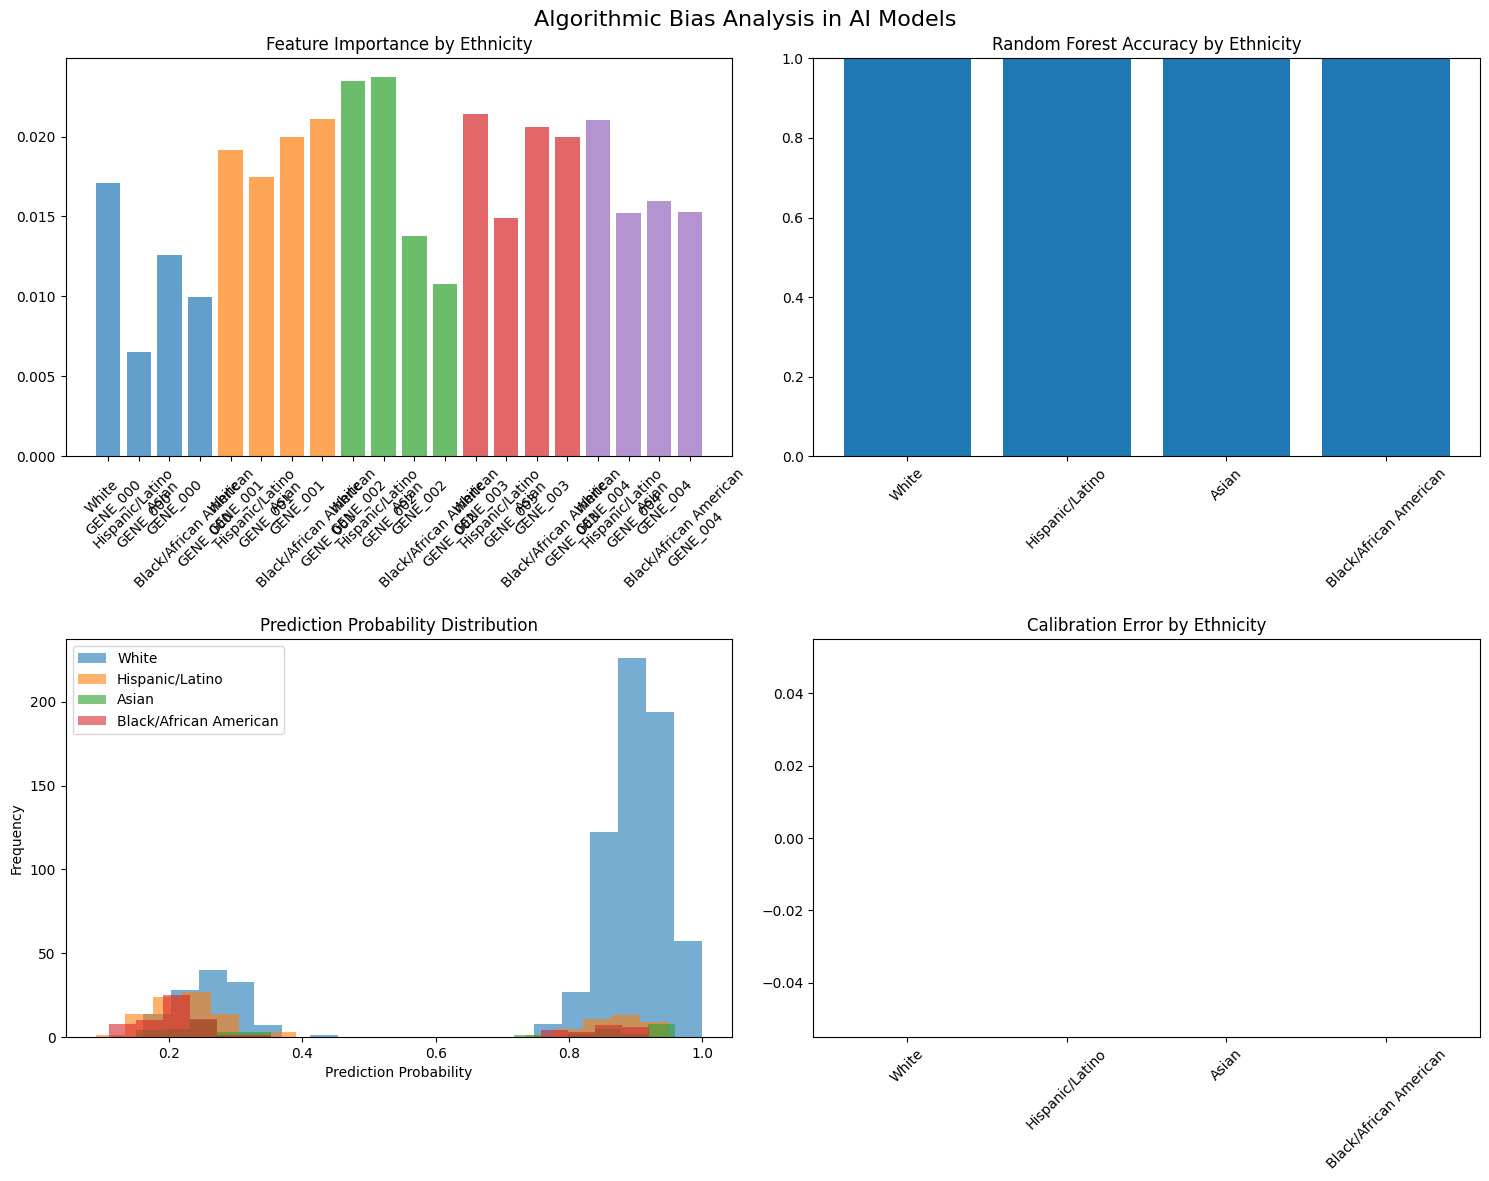


Analysis complete! Check 'analysis/algorithmic_bias_visualizations.png' for visualizations.


In [25]:
# Run the analysis
main()